## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [2]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}
# matplotlib.rcParams['font.family'] = ['Noto Sans Mono CJK TC', 'sans-serif']
plt.rcParams["font.sans-serif"] = ["Noto Sans TC"]
# plt.plot((1, 2, 3), (4, 3, -1))
# plt.title("聲量圖")

## 2. 資料前處理

In [5]:
EBC = pd.read_csv("raw_data/raw_data.csv",index_col=0)  # 匯資料
EBC.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,877,Selina認愛了！小鮮肉男友首曝光 親密互動全被拍｜東森新聞,https://news.ebc.net.tw/news/article/305059,2022-03-03 12:44:00,娛樂,Selina（任家萱）離婚5年，今（3日）傳出好消息！她被陸媒拍到和神秘男子手勾手回酒店，一...,EBC
1,4490,算命阿姨發功 阿翰奪「走鐘獎最大獎」哽咽｜東森新聞,https://news.ebc.net.tw/news/article/342619,2022-10-30 11:42:00,娛樂,YouTuber最高榮譽殿堂，「走鐘獎」邁入第四屆，不少YouTuber共襄盛舉。以「九天玄...,EBC
2,1638,為照顧罹癌母！35歲男星突閃退演藝圈 媽媽2個月後逝世｜東森新聞,https://news.ebc.net.tw/news/article/312350,2022-04-15 06:40:00,娛樂,大陸歌手劉維曾赴韓拜師朴軫永，成為JYP首位中國練習生，後來在中國好聲音演唱范曉萱的歌曲因為...,EBC


In [6]:
# 移除網址格式
# 只留下中文字
EBC["artContent"] = EBC["artContent"].str.replace("(http|https)://.*", "", regex=True)
EBC["artTitle"] = EBC["artTitle"].str.replace("(http|https)://.*", "", regex=True)
EBC["artContent"] = EBC["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
EBC["artTitle"] = EBC["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
EBC['content'] = EBC['artContent']


EBC = EBC.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
EBC.head(3)

,content,artUrl,artCatagory,artDate
0,任家萱離婚年今日傳出好消息她被陸媒拍到和神秘男子手勾手回酒店一路上還不停跳躍看起來心情非常好...,https://news.ebc.net.tw/news/article/305059,娛樂,2022-03-03 12:44:00
1,最高榮譽殿堂走鐘獎邁入第四屆不少共襄盛舉以九天玄女紅遍全台的阿翰靠著算命阿姨奪下最佳影片獎在...,https://news.ebc.net.tw/news/article/342619,娛樂,2022-10-30 11:42:00
2,大陸歌手劉維曾赴韓拜師朴軫永成為首位中國練習生後來在中國好聲音演唱范曉萱的歌曲因為你是范曉萱...,https://news.ebc.net.tw/news/article/312350,娛樂,2022-04-15 06:40:00


In [7]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

EBC["words"] = EBC["content"].apply(getToken)
EBC.head()

Building prefix dict from d:\vscode\sna_group3\dict\dict.txt.big ...
2023-05-08 17:56:45,880 : DEBUG : Building prefix dict from d:\vscode\sna_group3\dict\dict.txt.big ...
Loading model from cache C:\Users\TSH13\AppData\Local\Temp\jieba.ud39a693a3199c8a92d2c9920519551c6.cache
2023-05-08 17:56:45,884 : DEBUG : Loading model from cache C:\Users\TSH13\AppData\Local\Temp\jieba.ud39a693a3199c8a92d2c9920519551c6.cache
Loading model cost 0.884 seconds.
2023-05-08 17:56:46,765 : DEBUG : Loading model cost 0.884 seconds.
Prefix dict has been built successfully.
2023-05-08 17:56:46,767 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,任家萱離婚年今日傳出好消息她被陸媒拍到和神秘男子手勾手回酒店一路上還不停跳躍看起來心情非常好...,https://news.ebc.net.tw/news/article/305059,娛樂,2022-03-03 12:44:00,"[任家萱, 離婚, 今日, 傳出, 好消息, 陸媒, 神秘, 男子, 手勾手, 酒店, 一路..."
1,最高榮譽殿堂走鐘獎邁入第四屆不少共襄盛舉以九天玄女紅遍全台的阿翰靠著算命阿姨奪下最佳影片獎在...,https://news.ebc.net.tw/news/article/342619,娛樂,2022-10-30 11:42:00,"[最高, 榮譽, 殿堂, 鐘獎, 邁入, 第四屆, 共襄盛舉, 九天, 玄女, 紅遍, 全台..."
2,大陸歌手劉維曾赴韓拜師朴軫永成為首位中國練習生後來在中國好聲音演唱范曉萱的歌曲因為你是范曉萱...,https://news.ebc.net.tw/news/article/312350,娛樂,2022-04-15 06:40:00,"[大陸歌手, 劉維, 赴韓, 拜師, 朴軫, 永成, 首位, 中國, 練習生, 中國, 聲音..."
3,華燈初上第三季日上線許多人為了避免被旁人爆雷在最短時間內拚命把劇追完飾演日式酒店小姐花子的劉...,https://news.ebc.net.tw/news/article/308225,娛樂,2022-03-22 13:47:00,"[華燈初上, 第三季, 上線, 許多, 人為, 避免, 爆雷, 短時間, 拚命, 把劇, 飾..."
4,年底最受矚目的犯罪懸疑國片由新銳導演陳奕甫執導找來張孝全陳昊森兩大男神攜手主演上映前舉辦多場...,https://news.ebc.net.tw/news/article/342847,娛樂,2022-11-01 11:25:00,"[年底, 最受, 矚目, 犯罪, 懸疑, 國片, 新銳, 導演, 執導, 找來, 張孝, 全..."


In [8]:
EBC['artCatagory'].unique()

array(['娛樂', '國際', '體育'], dtype=object)

## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文黨集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

簡單的範例說明 `gensim` bag of word 的方式

**4.1 正式處理新聞**

In [9]:
docs = EBC['words'].to_list()
docs[0]

['任家萱',
 '離婚',
 '今日',
 '傳出',
 '好消息',
 '陸媒',
 '神秘',
 '男子',
 '手勾手',
 '酒店',
 '一路上',
 '不停',
 '跳躍',
 '心情',
 '消息',
 '曝光',
 '微博',
 '發文',
 '寫下',
 '春暖花開',
 '春天',
 '大方',
 '愛小',
 '鮮肉',
 '近日',
 '大陸',
 '媒體',
 '一名',
 '神秘',
 '男子',
 '開車',
 '下班',
 '兩人還',
 '挽手',
 '酒店',
 '幾天',
 '兩人還',
 '一起',
 '醫院',
 '核酸',
 '檢測',
 '只見',
 '挽著',
 '男子',
 '手臂',
 '還在',
 '街頭',
 '蹦蹦跳跳',
 '心情',
 '陸媒',
 '搜狐',
 '娛樂',
 '報導',
 '去年',
 '活動',
 '現場',
 '已經',
 '接觸',
 '對象',
 '對方',
 '還小',
 '弟弟',
 '火車',
 '超夯',
 '陸上',
 '郵輪',
 '玩法',
 '懶人',
 '旅遊',
 '戀情',
 '隨後',
 '微博上',
 '寫下',
 '女人',
 '四十',
 '一枝花',
 '幸運',
 '戀情',
 '萌芽',
 '珍惜',
 '步伐',
 '小情',
 '請吃',
 '瓜且',
 '強調',
 '春天',
 '間接',
 '認愛',
 '新歡',
 '此文',
 '曝光',
 '粉絲',
 '留言',
 '恭喜',
 '姐姐',
 '這次',
 '一定',
 '獲得',
 '幸福',
 '開心',
 '開心',
 '寶貝',
 '春天',
 '萬物',
 '復甦',
 '季節',
 '希望',
 '四季如春',
 '任家萱',
 '寶貝',
 '幸福',
 '啊啊啊',
 '啊啊啊',
 '寶貝',
 '公主',
 '記得',
 '幸福',
 '年歲',
 '前夫',
 '張承中',
 '離婚',
 '小歲',
 '華燈初上',
 '男星',
 '張軒',
 '大陸',
 '真人秀',
 '實境',
 '節目',
 '女兒',
 '戀愛',
 '上演',
 '甜蜜',
 '弟戀',
 '還在',
 '節目',
 '最後',
 '一集',
 '宣布',
 '交往',

In [10]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2023-05-08 17:57:06,765 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-05-08 17:57:07,380 : INFO : built Dictionary<71997 unique tokens: ['一名', '一定', '一枝花', '一起', '一路上']...> from 4098 documents (total 741105 corpus positions)
2023-05-08 17:57:07,382 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<71997 unique tokens: ['一名', '一定', '一枝花', '一起', '一路上']...> from 4098 documents (total 741105 corpus positions)", 'datetime': '2023-05-08T17:57:07.382956', 'gensim': '4.3.1', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}
2023-05-08 17:57:07,444 : INFO : discarding 63868 tokens: [('一枝花', 1), ('一集', 9), ('任家萱', 3), ('啊啊啊', 9), ('四十', 1), ('四季如春', 1), ('季節', 4), ('小情', 1), ('弟戀', 5), ('張承中', 2)]...
2023-05-08 17:57:07,445 : INFO : keeping 8129 tokens which were in no less than 10 and no more than 4057 (=99.0%) documents
2023-05-08 17:57:07,472 : INFO : resulting dictiona

Dictionary<8129 unique tokens: ['一名', '一定', '一起', '一路上', '上演']...>


In [11]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一名: 0
一定: 1
一起: 2
一路上: 3
上演: 4
下去: 5
下班: 6
不停: 7
之後: 8
交往: 9
今日: 10
傳出: 11


將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。<br>
每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>



In [32]:
pprint(" ".join(EBC['words'].iloc[50]))


('藝人 小嫻 去年 南下 墾丁 打工 換宿 努力 享受 生活 因緣際會 金剛 李信 相戀 兩人 一同 經營 雞翅 副業 怎料 嫻突 限時 動態 粉絲 幫忙 '
 '投票決定 兩人 是否 退出 擺攤 經紀人 公布 背後 原因 限時 夏日 輕鬆 變纖女 今天 明天 藝人 小嫻 男星 金剛 李信 公開 認愛後 交往 至今 '
 '感情 穩定 小倆口 經營 雞翅 副業 販賣 手工 編織 手環 雞翅 生意 一度 好到 爆單 缺貨 小嫻 突然 思考 退出 擺攤 消息 一出 許多 粉絲 '
 '感到 小嫻 發出 限時 動態 設置 投票 功能 粉絲 決定 兩人要 退出 擺攤 共有 選項 分別 是否 另尋 出路 消息 一出 引發 外界 好奇 兩人 '
 '擺攤 是否 遭遇 困難 報導 小嫻 經紀人 表示 近日 本土 疫情 延燒 墾丁 台灣 傳出 確診 雞翅 物料 短缺 嫻動 放棄 念頭 小嫻 透過 三立 '
 '新聞網 表示 現在 問題 解決 回到 擺攤 繼續 擺攤 想要 光顧 小嫻 雞翅 生意 粉絲 前往 墾丁 大街 支持 了解 日前 金剛 小心 滑倒 把手 '
 '摔傷 石膏 開刀 治療 受傷 金剛 堅持 陪伴 小嫻 日小嫻 臉書 俏皮 寫下 人手 受傷 擺攤 不來 照片 兩人 露出 燦爛 笑容 樂觀 面對 生活')


In [33]:
dictionary.doc2bow(EBC['words'].iloc[50])[:10]

[(9, 1),
 (11, 1),
 (12, 4),
 (16, 1),
 (19, 1),
 (30, 1),
 (49, 1),
 (66, 2),
 (74, 1),
 (81, 4)]

In [14]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [15]:
type(corpus)

list

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [16]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=100, # 生成幾個主題數
    random_state=2023, # 亂數
)

2023-05-08 17:57:08,099 : INFO : using symmetric alpha at 0.01
2023-05-08 17:57:08,100 : INFO : using symmetric eta at 0.01
2023-05-08 17:57:08,102 : INFO : using serial LDA version on this node
2023-05-08 17:57:08,162 : INFO : running online (single-pass) LDA training, 100 topics, 1 passes over the supplied corpus of 4098 documents, updating model once every 2000 documents, evaluating perplexity every 4098 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-08 17:57:08,163 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-05-08 17:57:08,163 : INFO : PROGRESS: pass 0, at document #2000/4098
2023-05-08 17:57:21,207 : INFO : merging changes from 2000 documents into a model of 4098 documents
2023-05-08 17:57:21,246 : INFO : topic #26 (0.010): 0.010*"網友" + 0.009*"表示" + 0.007*"兩人" + 0.007*"相當" + 0.005*"女兒" + 0.005*"余苑" + 0.004*"分手" + 0.004*"余天" + 0.004*"已經" + 0.004*"影片"
2023-05-08 1

**4.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>



In [17]:
ldamodel.print_topic(50)

'0.017*"這顆" + 0.010*"表示" + 0.010*"勝出" + 0.010*"出生" + 0.008*"近藤" + 0.007*"壓迫" + 0.007*"生下" + 0.007*"症狀" + 0.007*"醫院" + 0.007*"生子"'

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [18]:
ldamodel.get_document_topics(corpus[0])

[(16, 0.053044915),
 (17, 0.01618829),
 (45, 0.018738361),
 (63, 0.1997009),
 (65, 0.010580584),
 (66, 0.11690966),
 (68, 0.45235926),
 (83, 0.060415242),
 (94, 0.06511583)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [19]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2023-05-08 17:57:53,894 : INFO : -14.137 per-word bound, 18015.4 perplexity estimate based on a held-out corpus of 4098 documents with 577682 words


-14.136945476803252

In [20]:
np.exp2(-perplexity)

18015.43012755744

In [21]:
# pmi
PMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

2023-05-08 17:57:54,049 : INFO : using ParallelWordOccurrenceAccumulator<processes=15, batch_size=64> to estimate probabilities from sliding windows
2023-05-08 17:58:07,435 : INFO : 1 batches submitted to accumulate stats from 64 documents (10718 virtual)
2023-05-08 17:58:07,438 : INFO : 2 batches submitted to accumulate stats from 128 documents (21505 virtual)
2023-05-08 17:58:07,442 : INFO : 3 batches submitted to accumulate stats from 192 documents (32741 virtual)
2023-05-08 17:58:07,447 : INFO : 4 batches submitted to accumulate stats from 256 documents (44358 virtual)
2023-05-08 17:58:07,452 : INFO : 5 batches submitted to accumulate stats from 320 documents (55805 virtual)
2023-05-08 17:58:07,458 : INFO : 6 batches submitted to accumulate stats from 384 documents (66954 virtual)
2023-05-08 17:58:07,464 : INFO : 7 batches submitted to accumulate stats from 448 documents (78327 virtual)
2023-05-08 17:58:07,468 : INFO : 8 batches submitted to accumulate stats from 512 documents (910

這個主題的 PMI score:  -0.17496484053945363


In [22]:
PMI_model_lda.get_coherence_per_topic()

[-0.17149522688054325,
 -0.2942108816400058,
 -0.06785389797996856,
 -0.26742329799112763,
 -0.0577708843813165,
 -0.27633531505346204,
 -0.12188257208724915,
 -0.02446742846891604,
 -0.20208797399785386,
 -0.2903422978007255,
 -0.21898207857089164,
 -0.1816457068653516,
 -0.2894817502418722,
 -0.08652853014507517,
 -0.04759828452829636,
 -0.20273549387941936,
 -0.20996297210135656,
 -0.20609592155816128,
 -0.19329526014883333,
 -0.1500759230904079,
 -0.23415921057679148,
 -0.15482389621300224,
 -0.21773826185708317,
 -0.20887620184763414,
 -0.23293541908591658,
 0.06805986920515247,
 -0.25327936575606874,
 -0.14773780252084764,
 -0.14210246661984782,
 -0.1010005203582348,
 -0.07873671292314756,
 -0.12311376107269022,
 -0.26738997654481095,
 -0.24145779892913394,
 -0.25088637793590146,
 -0.04655060277059856,
 -0.1418388252445847,
 -0.22833160371023462,
 -0.2579599460960044,
 -0.22450801822817298,
 -0.13298621781788283,
 -0.18101666637260874,
 -0.2472381375380902,
 -0.19709645902662715,

`npmi` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡以 perplexity 為指標，因為gensim套件的問題，我們將其進行轉換。<br>

* 使用 LdaMulticore()` 減少運算時間

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [23]:
from gensim.models.ldamulticore import LdaMulticore
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2023-05-08 17:58:15,731 : INFO : using symmetric alpha at 0.5
2023-05-08 17:58:15,732 : INFO : using symmetric eta at 0.5
2023-05-08 17:58:15,734 : INFO : using serial LDA version on this node
2023-05-08 17:58:15,736 : INFO : running online LDA training, 2 topics, 5 passes over the supplied corpus of 4098 documents, updating every 30000 documents, evaluating every ~4098 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-08 17:58:15,736 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-05-08 17:58:15,737 : INFO : training LDA model using 15 processes
2023-05-08 17:58:28,336 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/4098, outstanding queue size 1
2023-05-08 17:58:28,383 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/4098, outstanding queue size 2
2023-05-08 17:58:28,445 : INFO : PROGRESS: pass 0, dispatched chunk #2 = document

KeyboardInterrupt: 

In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,4556.075092,0.044405
1,3,4300.309075,0.047495
2,4,4446.248429,0.055452
3,5,4423.680874,0.053572
4,6,4240.490280,0.056774
5,7,4022.200944,0.045698
6,8,4094.070114,0.024802
7,9,4242.770145,0.036930


<AxesSubplot:xlabel='topic_num'>

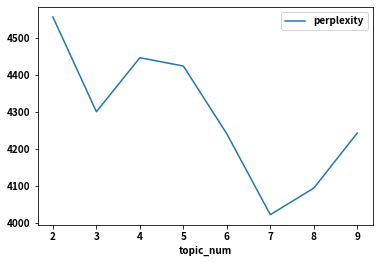

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<AxesSubplot:xlabel='topic_num'>

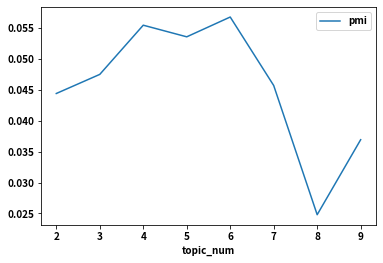

In [ ]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 7是最低，coherence 最高則是 6

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 四個主題數，因此有四個圈圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 8 來做 LDAvis 的結果範例

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 7,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2023-05-08 17:39:02,771 : INFO : using symmetric alpha at 0.14285714285714285
2023-05-08 17:39:02,773 : INFO : using symmetric eta at 0.14285714285714285
2023-05-08 17:39:02,775 : INFO : using serial LDA version on this node
2023-05-08 17:39:02,784 : INFO : running online (multi-pass) LDA training, 7 topics, 5 passes over the supplied corpus of 4098 documents, updating model once every 2000 documents, evaluating perplexity every 4098 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-08 17:39:02,786 : INFO : PROGRESS: pass 0, at document #2000/4098
2023-05-08 17:39:03,899 : INFO : merging changes from 2000 documents into a model of 4098 documents
2023-05-08 17:39:03,907 : INFO : topic #6 (0.143): 0.006*"網友" + 0.006*"表示" + 0.004*"兩人" + 0.004*"已經" + 0.003*"影片" + 0.003*"目前" + 0.003*"小姐" + 0.003*"當時" + 0.003*"相當" + 0.003*"時間"
2023-05-08 17:39:03,910 : INFO : topic #1 (0.143): 0.010*"表示" + 0.008*"網友" + 0.004*"粉絲" + 0.004*"影片" + 0.004*"孩子" + 0.004*"相當" + 0.003*"看到" + 0

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.157518  0.121568       1        1  34.966436
4      0.188616  0.067701       2        1  19.911843
5      0.141092 -0.084030       3        1  14.546806
1     -0.178229  0.086957       4        1  10.718855
2     -0.151047 -0.208010       5        1  10.036191
6      0.075552 -0.104484       6        1   6.380825
0     -0.233503  0.120298       7        1   3.439044, topic_info=      Term         Freq        Total Category  logprob  loglift
10090   大谷  1004.000000  1004.000000  Default  30.0000  30.0000
1369    日本  1385.000000  1385.000000  Default  29.0000  29.0000
13671   育成  1139.000000  1139.000000  Default  28.0000  28.0000
2926    經典  1183.000000  1183.000000  Default  27.0000  27.0000
7227   烏克蘭  1125.000000  1125.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
13837   二壘    69.222274   192.394821   Topic7  -5.7476   2.3477
63      最後   118.268732  1305.633216   Topic7  -5.2119   0.9685
5202    聯盟   106.870636   942.793490   Topic7  -5.3133   1.1927
979     世界    91.139312  1233.010264   Topic7  -5.4725   0.7652
1004    台灣    86.084467  2724.596164   Topic7  -5.5296  -0.0848

[523 rows x 6 columns], token_table=       Topic      Freq Term
term                       
0          1  0.358269   一名
0          2  0.540533   一名
0          3  0.022685   一名
0          4  0.046935   一名
0          5  0.000782   一名
...      ...       ...  ...
11165      6  0.992810  魂東森
9100       2  0.813810   魔獸
9100       4  0.003857   魔獸
9100       5  0.181275   魔獸
11534      4  0.989094   龍隊

[1414 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 6, 2, 3, 7, 1])

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7`, `python3.8` 可正常執行

In [ ]:
import guidedlda

In [ ]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一名', '一定', '一起', '一路上', '一集', '上演', '下去', '下班', '不停', '之後')

In [ ]:
word2id = dictionary.token2id

In [ ]:
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=7, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_confidence=1)


2023-05-08 17:40:10,840 : INFO : n_documents: 4098
2023-05-08 17:40:10,841 : INFO : vocab_size: 14437
2023-05-08 17:40:10,842 : INFO : n_words: 630874
2023-05-08 17:40:10,842 : INFO : n_topics: 7
2023-05-08 17:40:10,843 : INFO : n_iter: 100
2023-05-08 17:40:13,109 : INFO : <0> log likelihood: -7044592
2023-05-08 17:40:13,717 : INFO : <20> log likelihood: -5574215
2023-05-08 17:40:14,294 : INFO : <40> log likelihood: -5461923
2023-05-08 17:40:14,877 : INFO : <60> log likelihood: -5417948
2023-05-08 17:40:15,471 : INFO : <80> log likelihood: -5393544
2023-05-08 17:40:16,051 : INFO : <99> log likelihood: -5377260


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 經典 中華隊 球迷 棒球 球員 比賽 聯盟 投手 台灣 世界
Topic 1: 表示 孩子 透露 希望 女兒 媽媽 已經 真的 現在 兩人
Topic 2: 網友 表示 直播 萬元 公司 對方 離婚 台幣 影片 認為
Topic 3: 世界盃 比賽 阿根廷 選手 卡達 今天 晉級 冠軍 拿下 球員
Topic 4: 烏克蘭 俄羅斯 美國 中國 台灣 表示 總統 國家 今天 俄軍
Topic 5: 網友 粉絲 台灣 真的 影片 節目 許多 照片 表示 相當
Topic 6: 發生 一名 報導 發現 表示 影片 出現 目前 警方 已經


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.134770  0.142039       1        1  16.881989
5     -0.047233 -0.201052       2        1  16.091810
1     -0.130529 -0.189685       3        1  16.074299
0      0.263157 -0.049828       4        1  16.055372
4     -0.033568  0.193306       5        1  13.153884
3      0.291285  0.052860       6        1  10.898996
2     -0.208343  0.052360       7        1  10.843650, topic_info=     Term         Freq        Total Category  logprob  loglift
8472  中華隊  1686.000000  1686.000000  Default  30.0000  30.0000
2926   經典  1882.000000  1882.000000  Default  29.0000  29.0000
7227  烏克蘭  1439.000000  1439.000000  Default  28.0000  28.0000
270    比賽  1874.000000  1874.000000  Default  27.0000  27.0000
7597   棒球  1193.000000  1193.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
21     報導   321.377667  1653.365433   Topic7  -5.3607   0.5836
258    指出   235.546546  1146.162776   Topic7  -5.6714   0.6393
377    發現   228.560292  1170.244068   Topic7  -5.7015   0.5884
177   沒想到   200.615275   779.805208   Topic7  -5.8319   0.8639
63     最後   203.609384  1499.592362   Topic7  -5.8171   0.2248

[509 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.721492   一名
0         6  0.012658   一名
0         7  0.265813   一名
522       1  0.089142   一直
522       2  0.054321   一直
...     ...       ...  ...
1581      7  0.029770   高中
2711      2  0.930921   高雄
2711      6  0.070138   高雄
9100      2  1.001191   魔獸
6013      2  1.000901   鳳梨

[948 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 2, 1, 5, 4, 3])

In [ ]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_confidence=1)

2023-05-08 17:40:18,411 : INFO : n_documents: 4098
2023-05-08 17:40:18,412 : INFO : vocab_size: 14437
2023-05-08 17:40:18,412 : INFO : n_words: 630874
2023-05-08 17:40:18,413 : INFO : n_topics: 6
2023-05-08 17:40:18,413 : INFO : n_iter: 100
2023-05-08 17:40:20,328 : INFO : <0> log likelihood: -6898262
2023-05-08 17:40:20,854 : INFO : <20> log likelihood: -5540121
2023-05-08 17:40:21,381 : INFO : <40> log likelihood: -5444289
2023-05-08 17:40:21,896 : INFO : <60> log likelihood: -5411857
2023-05-08 17:40:22,410 : INFO : <80> log likelihood: -5392476
2023-05-08 17:40:22,930 : INFO : <99> log likelihood: -5383360


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 中華隊 比賽 經典 今天 日本 球員 投手 世界 棒球 高中
Topic 1: 一名 發生 報導 發現 表示 男子 女子 警方 孩子 醫院
Topic 2: 烏克蘭 俄羅斯 美國 世界盃 表示 阿根廷 報導 國家 總統 俄軍
Topic 3: 台灣 球迷 球員 選手 經典 比賽 聯盟 棒球 賽事 世界
Topic 4: 中國 台灣 表示 大陸 指出 認為 公司 對此 汪小菲 問題
Topic 5: 網友 表示 粉絲 真的 兩人 透露 相當 希望 節目 照片


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.032743 -0.163200       1        1  27.989575
0     -0.290395  0.004774       2        1  18.175638
1      0.215103  0.062383       3        1  17.801363
4      0.162608 -0.158587       4        1  12.280278
3     -0.163383 -0.039026       5        1  11.885319
2      0.043325  0.293655       6        1  11.867828, topic_info=     Term         Freq        Total Category  logprob  loglift
7227  烏克蘭  1439.000000  1439.000000  Default  30.0000  30.0000
8472  中華隊  1686.000000  1686.000000  Default  29.0000  29.0000
4429   球迷  1641.000000  1641.000000  Default  28.0000  28.0000
9555  俄羅斯  1089.000000  1089.000000  Default  27.0000  27.0000
270    比賽  1875.000000  1875.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
258    指出   269.530027  1146.229259   Topic6  -5.6268   0.6838
37     已經   276.517584  1804.701669   Topic6  -5.6012   0.2555
854    進行   253.558469  1039.453809   Topic6  -5.6879   0.7205
60     旅遊   240.581578   759.024446   Topic6  -5.7405   0.9824
73     玩法   238.585133   672.127707   Topic6  -5.7488   1.0956

[445 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.026100   一名
0         2  0.013446   一名
0         3  0.920624   一名
0         6  0.039546   一名
2         1  0.509609   一起
...     ...       ...  ...
1581      2  0.948420   高中
1581      3  0.021647   高中
2711      1  0.133928   高雄
2711      5  0.867345   高雄
9100      5  1.001520   魔獸

[814 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 5, 4, 3])

In [ ]:
# # EBC.loc[EBC['artCatagory']=='兩岸', "content"].to_csv("tmp.csv")
# EBC.loc[EBC['artCatagory']=='運動', "words"].to_csv("words.csv")
# EBC.loc[EBC['artCatagory']=='國際', "words"].to_csv("words_stock.csv")


In [ ]:
# EBC.loc[EBC['artCatagory']=='運動', "words"].explode().value_counts().to_csv("words_count.csv")
# EBC.loc[EBC['artCatagory']=='國際', "words"].explode().value_counts().to_csv("words_count_stock.csv")

## 7. 主題分佈的應用，搭配其他文章資訊

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = best_model.get_document_topics(corpus)

In [ ]:
topics_doc[100]

[(3, 0.9945858)]

In [ ]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.        , 0.        , 0.        , ..., 0.07823034, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03305633, ..., 0.74106169, 0.        ,
        0.        ],
       ...,
       [0.        , 0.99296522, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.98954976, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.95738012, ..., 0.        , 0.        ,
        0.02802438]])

In [ ]:
EBC['topic_label'] = m_theta.argmax(axis=1) + 1

In [ ]:
EBC['topic_label'].value_counts()

topic_label
4    1483
5     837
6     575
3     477
2     436
7     193
1      97
Name: count, dtype: int64

In [ ]:
EBC.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,任家萱離婚年今日傳出好消息她被陸媒拍到和神秘男子手勾手回酒店一路上還不停跳躍看起來心情非常好...,https://news.ebc.net.tw/news/article/305059,娛樂,2022-03-03 12:44:00,"[任家萱, 離婚, 今日, 傳出, 好消息, 陸媒, 神秘, 男子, 手勾手, 酒店, 一路...",4
1,最高榮譽殿堂走鐘獎邁入第四屆不少共襄盛舉以九天玄女紅遍全台的阿翰靠著算命阿姨奪下最佳影片獎在...,https://news.ebc.net.tw/news/article/342619,娛樂,2022-10-30 11:42:00,"[最高, 榮譽, 殿堂, 鐘獎, 邁入, 第四屆, 共襄盛舉, 九天, 玄女, 紅遍, 全台...",4
2,大陸歌手劉維曾赴韓拜師朴軫永成為首位中國練習生後來在中國好聲音演唱范曉萱的歌曲因為你是范曉萱...,https://news.ebc.net.tw/news/article/312350,娛樂,2022-04-15 06:40:00,"[大陸歌手, 劉維, 赴韓, 拜師, 朴軫, 永成, 首位, 中國, 練習生, 中國, 聲音...",5
3,華燈初上第三季日上線許多人為了避免被旁人爆雷在最短時間內拚命把劇追完飾演日式酒店小姐花子的劉...,https://news.ebc.net.tw/news/article/308225,娛樂,2022-03-22 13:47:00,"[華燈初上, 第三季, 上線, 許多, 人為, 避免, 爆雷, 短時間, 拚命, 把劇, 飾...",4
4,年底最受矚目的犯罪懸疑國片由新銳導演陳奕甫執導找來張孝全陳昊森兩大男神攜手主演上映前舉辦多場...,https://news.ebc.net.tw/news/article/342847,娛樂,2022-11-01 11:25:00,"[年底, 最受, 矚目, 犯罪, 懸疑, 國片, 新銳, 導演, 執導, 找來, 張孝, 全...",4


In [ ]:
EBC['artDate'] = pd.to_datetime(EBC['artDate'])


In [ ]:
EBC['artDate'].dt.year

0       2022
1       2022
2       2022
3       2022
4       2022
        ... 
4093    2023
4094    2023
4095    2023
4096    2023
4097    2023
Name: artDate, Length: 4098, dtype: int32

In [ ]:
EBC.groupby(EBC['artDate'].dt.year)['topic_label'].value_counts(normalize=True)

artDate  topic_label
2022     4              0.395775
         5              0.230282
         6              0.169718
         3              0.136620
         7              0.036972
         2              0.026761
         1              0.003873
2023     2              0.286169
         4              0.285374
         5              0.145469
         6              0.073927
         3              0.070747
         7              0.069952
         1              0.068362
Name: proportion, dtype: float64

In [ ]:
date_topic = EBC.groupby(EBC['artDate'].dt.year)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5,6,7
artDate,,,,,,,
2022,0.003873,0.026761,0.136620,0.395775,0.230282,0.169718,0.036972
2023,0.068362,0.286169,0.070747,0.285374,0.145469,0.073927,0.069952


<AxesSubplot:xlabel='artDate'>

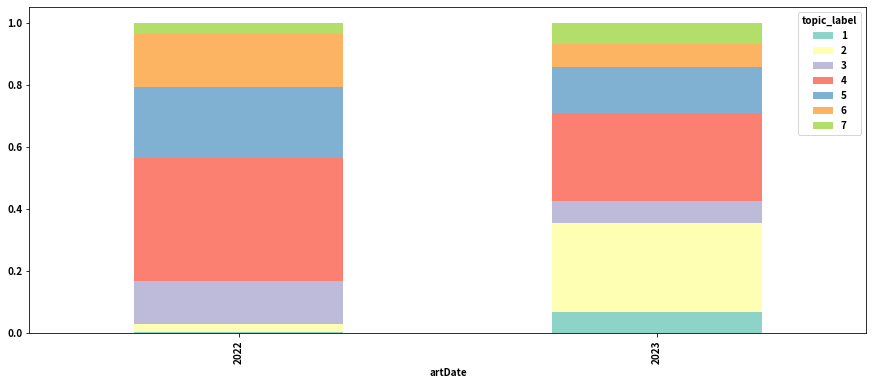

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)

透過搭配文章的資訊（例如日期等），可以讓主題模型的結果做出更多的分析應用